# Random Forest

In [1]:
import pandas as pd
from sklearn import preprocessing
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import joblib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
RANDOM_STATE = 42

## Feature Engineering

In [3]:
# Constant
drop_cols = ["Name", "SibSp", "Parch", "Ticket"]
obj_col = "Survived"
train_df_path = "data/train.csv"
test_df_path = "data/test.csv"

## feature engineering
def feature_engineering(raw_df):
    df = raw_df.copy()
    df["Cabin"] = df["Cabin"].apply(lambda x: x[:1] if x is not np.nan else np.nan)
    df["Ticket"] = df["Ticket"].apply(lambda x: str(x).split()[0])
    df["Family"] = df["SibSp"] + df["Parch"]
    return df

In [4]:
# cat
def to_category(train_df, test_df):
    cat = ["Sex", "Cabin", "Embarked"]
    mappings = {}
    for col in cat:
        le = preprocessing.LabelEncoder()
        train_df[col] = le.fit_transform(train_df[col])
        test_df[col] = le.transform(test_df[col])
        mappings[col] = dict(zip(le.classes_, le.transform(le.classes_)))
    return train_df, test_df, mappings

In [5]:
def get_predictions(clf, X, t=0.5):
    y_proba = clf.predict_proba(X)[:, 1]
    predictions  = 1*(y_proba >= t)
    return y_proba, predictions

## Metrics and Plots

In [6]:
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    RocCurveDisplay,
    precision_recall_curve,
    PrecisionRecallDisplay,
)

In [7]:
def get_metrics(y, ypred, yproba):
    return {
        "roc_auc": roc_auc_score(y, yproba),
        "average_precision": average_precision_score(y, yproba),
        "accuracy": accuracy_score(y, ypred),
        "precision": precision_score(y, ypred),
        "recall": recall_score(y, ypred),
        "f1": f1_score(y, ypred),
        "cm": confusion_matrix(y, ypred)
    }

In [8]:
def get_plots(y, ypred, yproba):
    cm = confusion_matrix(y, ypred)
    cm_plot = ConfusionMatrixDisplay(cm).plot()
    fpr, tpr, _ = roc_curve(y, yproba)
    roc_plot = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    prec, recall, _ = precision_recall_curve(y, yproba)
    pr_plot = PrecisionRecallDisplay(precision=prec, recall=recall).plot()
    return {
        'cm': cm_plot,
        'roc': roc_plot,
        'pr': pr_plot
    }

In [9]:
# evaluation
def eval_model(clf, X, y):
    y_proba, y_pred = get_predictions(clf, X)
    metrics =  get_metrics(y, y_pred, y_proba)
    plots = get_plots(y, y_pred, y_proba)
    return metrics, plots

## Working On Actual Data

Our test set here actually has no ground truth. We'll thus use the original training set and split it up into train and validation. 

In [10]:
print("Loading data...")
df_train = pd.read_csv(train_df_path, index_col="PassengerId")
df_test = pd.read_csv(test_df_path, index_col="PassengerId")

print("Engineering features...")
y = df_train[obj_col]
train_df = feature_engineering(df_train).drop(drop_cols + [obj_col], axis=1)
test_df = feature_engineering(df_test).drop(drop_cols, axis=1)
train_df, test_df, mappings = to_category(train_df, test_df)

Loading data...
Engineering features...


Here are the features in the data:

```
survival - Survival (0 = No; 1 = Yes)
class - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
name - Name
sex - Sex
age - Age
sibsp - Number of Siblings/Spouses Aboard
parch - Number of Parents/Children Aboard
ticket - Ticket Number
fare - Passenger Fare
cabin - Cabin
embarked - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)
boat - Lifeboat (if survived)
body - Body number (if did not survive and body was recovered)
```

In [11]:
mappings

{'Sex': {'female': 0, 'male': 1},
 'Cabin': {'A': 0,
  'B': 1,
  'C': 2,
  'D': 3,
  'E': 4,
  'F': 5,
  'G': 6,
  'T': 7,
  nan: 8},
 'Embarked': {'C': 0, 'Q': 1, 'S': 2, nan: 3}}

## Some EDA

In [12]:
df_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


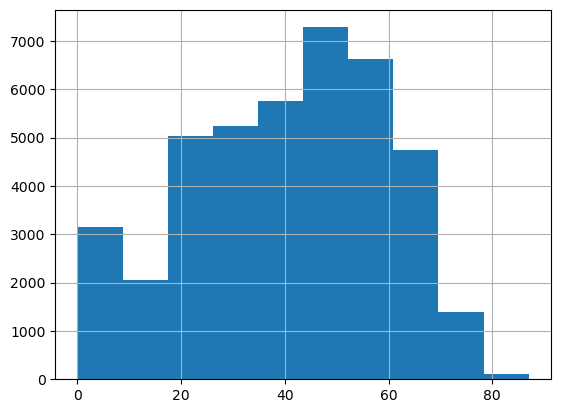

In [13]:
df_train[df_train.Survived==1].Age.hist()
plt.show()

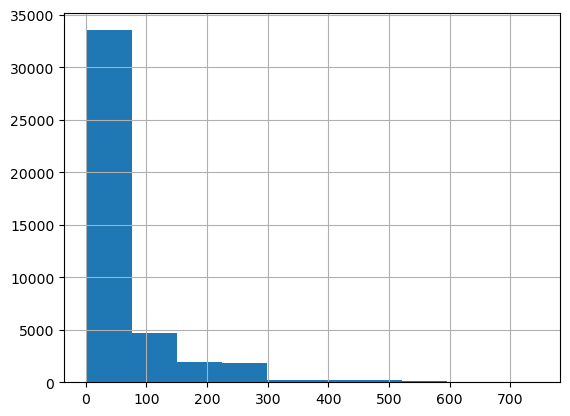

In [14]:
df_train[df_train.Survived==1].Fare.hist()
plt.show()

In [15]:
df_test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
100000,3,"Holliday, Daniel",male,19.0,0,0,24745,63.01,NaN,S
100001,3,"Nguyen, Lorraine",female,53.0,0,0,13264,5.81,NaN,S
100002,1,"Harris, Heather",female,19.0,0,0,25990,38.91,B15315,C
100003,2,"Larsen, Eric",male,25.0,0,0,314011,12.93,NaN,S
100004,1,"Cleary, Sarah",female,17.0,0,2,26203,26.89,B22515,C


In [16]:
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

In [17]:
train_df.head()

,Pclass,Sex,Age,Fare,Cabin,Embarked,Family
PassengerId,,,,,,,
0,1,1,0.00,27.14,2,2,2
1,3,1,0.00,13.35,8,2,0
2,3,1,0.33,71.29,8,2,3
3,3,1,19.00,13.04,8,2,0
4,3,1,25.00,7.76,8,2,0


In [18]:
train_df.describe()

,Pclass,Sex,Age,Fare,Cabin,Embarked,Family
count,100000.000000,100000.00000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000
mean,2.106910,0.56114,37.09281,43.870465,5.983550,1.504520,0.852250
std,0.837727,0.49625,19.26607,69.560745,3.023404,0.835899,1.412792
min,1.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.00000,24.00000,10.020000,2.000000,1.000000,0.000000
50%,2.000000,1.00000,38.00000,24.440000,8.000000,2.000000,0.000000
75%,3.000000,1.00000,53.00000,33.470000,8.000000,2.000000,1.000000
max,3.000000,1.00000,87.00000,744.660000,8.000000,3.000000,17.000000


In [19]:
for col in ['Pclass', 'Sex', 'Cabin', 'Embarked', 'Family']:
    print(col, train_df[col].unique())

Pclass [1 3 2]
Sex [1 0]
Cabin [2 8 0 3 1 4 5 6 7]
Embarked [2 0 1 3]
Family [ 2  0  3  1  4  6  5  9  7 10  8 13 11 17 12 14]


## Now train with systematic hyperparameters

In [ ]:
print("Training model...")
X_train, X_test, y_train, y_test = train_test_split(
    train_df, y, test_size=0.33, random_state=RANDOM_STATE, stratify=y
)

In [ ]:
def fit_model(train_X, train_y, max_depth=None, random_state=42):
    clf = RandomForestClassifier(n_estimators=200, max_depth=max_depth, random_state=random_state)
    clf.fit(train_X, train_y)
    return clf

In [23]:
import uuid

In [27]:
metrics = []
for max_depth in [1, 5, 8, 10, 12, 15, 20, None]:
    run_id = uuid.uuid4()
    print(f"Training Model {max_depth}")
    model = fit_model(X_train, y_train, max_depth=max_depth)
    print("Evaluating Model")
    train_metrics, train_plots = eval_model(model, X_train, y_train)
    print("Train metrics:")
    print(train_metrics)
    train_metrics['data'] = 'train'
    train_metrics['n_est'] = 200
    train_metrics['max_depth'] = max_depth
    train_metrics['run_id'] = run_id
    metrics.append(train_metrics)
    for k in train_plots:
        train_plots[k].figure_.savefig(f"plots/rf_train_{run_id}_{k}.png")
    test_metrics, test_plots = eval_model(model, X_test, y_test)
    print("Test metrics:")
    print(test_metrics)
    test_metrics['data'] = 'test'
    test_metrics['n_est'] = 200
    test_metrics['max_depth'] = max_depth
    test_metrics['run_id'] = run_id
    metrics.append(test_metrics)
    for k in test_plots:
        test_plots[k].figure_.savefig(f"plots/rf_test_{run_id}_{k}.png")
    joblib.dump(model, f"models/rf_{run_id}.joblib")
    print('----------------------')

Training Model 1
Evaluating Model
Train metrics:
{'roc_auc': 0.828111928941134, 'average_precision': 0.7466449339904188, 'accuracy': 0.7446417910447761, 'precision': 0.7792823290453622, 'recall': 0.5622666527094455, 'f1': 0.6532217200072968, 'cm': array([[33777,  4564],
       [12545, 16114]])}
Test metrics:
{'roc_auc': 0.8301644750077164, 'average_precision': 0.7472724903128243, 'accuracy': 0.7434242424242424, 'precision': 0.7763750244666275, 'recall': 0.5620262132483174, 'f1': 0.6520363292647845, 'cm': array([[16600,  2285],
       [ 6182,  7933]])}
----------------------
Training Model 5
Evaluating Model
Train metrics:
{'roc_auc': 0.8454758008206112, 'average_precision': 0.7975441271645314, 'accuracy': 0.779223880597015, 'precision': 0.7508774469008938, 'recall': 0.7241006315642555, 'f1': 0.7372459855051868, 'cm': array([[31456,  6885],
       [ 7907, 20752]])}
Test metrics:
{'roc_auc': 0.8463794143027447, 'average_precision': 0.7964224371563748, 'accuracy': 0.7761818181818182, 'pre

In [28]:
resudf = pd.DataFrame.from_records(metrics).set_index('run_id')
resudf

,roc_auc,average_precision,accuracy,precision,recall,f1,cm,data,n_est,max_depth
run_id,,,,,,,,,,
26c7ebcc-23c5-4f91-99a4-ca8cadcf720f,0.828112,0.746645,0.744642,0.779282,0.562267,0.653222,"[[33777, 4564], [12545, 16114]]",train,200,1.0
26c7ebcc-23c5-4f91-99a4-ca8cadcf720f,0.830164,0.747272,0.743424,0.776375,0.562026,0.652036,"[[16600, 2285], [6182, 7933]]",test,200,1.0
cfcd9f39-2645-4206-aebd-a9ceb67feba8,0.845476,0.797544,0.779224,0.750877,0.724101,0.737246,"[[31456, 6885], [7907, 20752]]",train,200,5.0
cfcd9f39-2645-4206-aebd-a9ceb67feba8,0.846379,0.796422,0.776182,0.746900,0.721077,0.733761,"[[15436, 3449], [3937, 10178]]",test,200,5.0
4dbd48a2-669a-49d3-80db-5fd93c06ff94,0.854433,0.811485,0.785343,0.764575,0.719809,0.741517,"[[31989, 6352], [8030, 20629]]",train,200,8.0
4dbd48a2-669a-49d3-80db-5fd93c06ff94,0.849187,0.801229,0.777667,0.755081,0.710733,0.732236,"[[15631, 3254], [4083, 10032]]",test,200,8.0
3f04fd84-64d2-43ca-b4e6-b56bbfba5c19,0.865339,0.828088,0.795194,0.772842,0.738163,0.755104,"[[32123, 6218], [7504, 21155]]",train,200,10.0
3f04fd84-64d2-43ca-b4e6-b56bbfba5c19,0.849424,0.802548,0.778939,0.753532,0.718030,0.735353,"[[15570, 3315], [3980, 10135]]",test,200,10.0
857a1f7c-6380-4b24-81c9-130b88c1967c,0.882952,0.853515,0.811000,0.787719,0.764053,0.775705,"[[32440, 5901], [6762, 21897]]",train,200,12.0


In [29]:
resudf.to_csv("results/results_rf.csv", header=True)